Reconstor!

In [8]:
curr_dir = '/home/vayzenbe/GitHub_Repos/GiNN/'
import sys
sys.path.insert(1, f'{curr_dir}Models')
import os, argparse
from collections import OrderedDict
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import cornet
import numpy as np
from load_stim import load_stim
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
stim_dir = f"{curr_dir}/Stim/"
weights_dir = f"{curr_dir}/Models/weights"

im_cond = ['front_face', 'schematic']
#im_cond = ['front_face']
model_types = 'face'

#Transformations for ImageNet
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])])
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],std=[1/0.229, 1/0.224, 1/0.225])

In [30]:
def save_recon(in_,out_):
    
    fig = plt.figure()

    out_ = out_.squeeze(0)
    out_ = inv_normalize(out_)
    out_ = out_.cpu().detach()
    
    in_ = in_.squeeze(0)
    in_ = inv_normalize(in_)
    in_ = in_.cpu().detach()
                     
    ax = fig.add_subplot(2, 1,2)
    plt.imshow(in_.permute(1, 2, 0))
    
    ax = fig.add_subplot(2, 1,1)
    plt.imshow(out_.permute(1, 2, 0))
    
    
    plt.axis('off')
    
    #plt.savefig(f'/home/GitHub_Repos/GiNN/Results/recon/{model}_{stim}.png', bbox_inches='tight', pad_inches = 0, dpi=150)
    
    

In [22]:
def load_model(model_type,epoch):
    #Load CorNet_Z
    model = getattr(cornet, 'cornet_z')
    model = model(pretrained=False, map_location='cpu') #load model into CPU so we can mess with it
    model = make_AE(model,True) #Add autoencoder so that weights load properly

    if model_type != 'random':
        checkpoint = torch.load(f'{weights_dir}/cornet_initial_{model_type}_{epoch}.pt')
        
        model.load_state_dict(checkpoint)
        
    #model = make_AE(model, False) #remove autoencoder so that only the avg pool is tested
    

    return model

In [23]:
#the model, and whether to attach an autoencoder to the end
def make_AE(model_,AE):
    
    model_ = model_.module  # remove DataParallel
    
    if AE == True:
        decode_layer = nn.Sequential(*list(model_[5][:-3]),nn.ReLU(), nn.ConvTranspose2d(1024, 3, 224)) #recreate decoding layer as autoencoder
    else:
        decode_layer = nn.Sequential(*list(model_[5][:-2])) #remove AE and just leave avgpool
        
    model_ = nn.Sequential(*list(model_[:-1])) #remove original decoding layer
    
    
    model_.add_module('5', decode_layer) #add AE decoding layer
    
    model_ = nn.DataParallel(model_.cuda()) #move back to GPU with dataparallel
    
    return model_
    

In [24]:
image_dir = f"/user_data/vayzenbe/OID_v6/face/"
val_dir = image_dir + 'validation'
val_dataset = load_stim(val_dir, transform=transform)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True, num_workers = 4, pin_memory=True)
data = next(iter(valloader))
data =data.cuda()

In [25]:

#this is all temporary
model = load_model('face',9)
model
model.eval()


DataParallel(
  (module): Sequential(
    (0): CORblock_Z(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (nonlin): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (output): Identity()
    )
    (1): CORblock_Z(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (nonlin): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (output): Identity()
    )
    (2): CORblock_Z(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (nonlin): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (output): Identity()
    )
    (3): CORblock_Z(
      (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (nonlin): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2,

In [26]:
out = model(data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


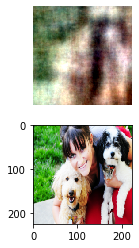

In [46]:

save_recon(data[90],out[90])

In [14]:

out = model